### **Movies - Images and Text -- Assignment [10pts]**

In this assignment, we will be dealing with a significantly larger and more realistic dataset consisting of both images and text. For this assignment we will use the MMIMDB dataset (https://github.com/johnarevalo/gmu-mmimdb), collected by Arévalo, González, Solorio and Montes-y-Gómez from the Universidad Nacional de Colombia, University of Houston, INAOE-México. If you collect a better dataset for this assignment I can give you credit in future iterations of this class. This dataset contains data corresponding to ~26,000 movies along with their plots (text) and their movie posters (images), and other information such as ratings and genres (categories). These are more movies than we will watch in a lifetime. We will use this dataset for movie genre classification. Each movie can be labeled with 27 categories of movies.

#### **1. Loading and Exploring the Dataset.**

##### **1.1 Dataset Download and Extraction**

First, we download the dataset, then we will create a Dataset class to load both the input movie posters (images), and input movie plots (texts), and the target movie genres (labels).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget -nc http://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz
# I found downloading from Google Drive with gdown is a lot faster.
#!pip -q install --upgrade --no-cache-dir gdown
#!gdown 173IhB80sQj2QfzTa10EsoUeEirb7LLlE
!tar xf mmimdb-256.tar.gz
#!tar xf mmimdb-512.tar.gz # I also keep a copy with images resized at 512 pixels on their largest side.
!pip install livelossplot --quiet
!pip -q install transformers==4.26.0
!pip -q install sentencepiece
!pip -q install accelerate

--2024-02-11 21:53:52--  http://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:80... connected.
HTTP request sent, awaiting response... 302 Found : Moved Temporarily
Location: https://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz [following]
--2024-02-11 21:53:52--  https://www.cs.rice.edu/~vo9/vislang/mmimdb-256.tar.gz
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 643479473 (614M) [application/x-gzip]
Saving to: ‘mmimdb-256.tar.gz’

mmimdb-256.tar.gz   100%[===================>] 613.67M  5.53MB/s    in 1m 55s  

2024-02-11 21:55:48 (5.31 MB/s) - ‘mmimdb-256.tar.gz’ saved [643479473/643479473]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

##### **1.2 Defining the Data Loader**

This is a typical step that we need to figure out on our own when starting a new project. Find some dataset, define a task, then get to know the data well enough so that we can write a data loader for it. Let's not take this work for granted. It is hard work. Please let's take some time analyzing the code below and let's ask questions in Piazza if there's any doubt about the code below. Let's pay especially close attention to the part of the code used for tokenizing the text. The goal of tokenization is to convert sequences of words/characters into a sequence of numbers representing each piece of the text. This typically involves having an ordered dictionary of words/tokens and then assigning the number in the dictionary to each word/token. We use the ```RobertaTokenizer``` from the huggingface transformers library which tokenizes inputs as expected by the RoBERTa model. RoBERTa or Robust BERT is a pretrained transformer neural network model that was trained by Facebook/Meta in 2019 which in turn was based on the BERT model which was trained by Google in 2018 on an enormous data collection to predict missing words in an input text. It was introduced in [https://arxiv.org/abs/1810.04805](https://https://arxiv.org/abs/1810.04805) and RoBERTa was introduced in [https://arxiv.org/abs/1907.11692](https://arxiv.org/abs/1907.11692). The images in this ```MovieDataset``` class will be loaded on the fly as they can not all fit in memory so they will be loaded in the ```__getitem__``` function, while the text will be tokenized and stored in some class variable in the ```__init__``` method.

In [ ]:
import torch, os, json
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer
from PIL import Image

class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, folder = 'dataset-resized-256max', split = 'dev',
                 image_transform = None,
                 tokenizer = RobertaTokenizer.from_pretrained('roberta-base')):
        self.json_dir = os.path.join(folder, split, 'metadata')
        self.image_dir = os.path.join(folder, split, 'images')
        self.image_transform = image_transform
        self.tokenizer = tokenizer

        # Category definitions of movies.
        self.categories = ['Action', 'Adult', 'Adventure', 'Animation', 'Biography',
                           'Comedy', 'Crime', 'Documentary', 'Drama',
                           'Family', 'Fantasy', 'Film-Noir', 'History',
                           'Horror', 'Music', 'Musical', 'Mystery', 'News',
                           'Reality-TV', 'Romance', 'Sci-Fi', 'Short',
                           'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
        self.categories2ids = {category: id for (id, category)
                               in enumerate(self.categories)}

        # Load JSON files.
        print('Loading %s ...' % self.json_dir, end = '')
        fdir = os.listdir(self.json_dir)
        self.metadata = [(fname[:-5], json.load(open(os.path.join(self.json_dir, fname))))
                     for fname in sorted(fdir) if not fname.startswith('.')]
        print(' finished')

        # Pre-tokenizing all sentences.
        # See documentation for what encode_plus does and each of its parameters.
        print('Tokenizing...', end = '')
        self.tokenized_plots = list()
        self.texts = list()
        for i in range(0, len(self.metadata)):
            text = self.metadata[i][1]['plot'][0]
            if self.tokenizer:
              encoded_text = self.tokenizer.encode_plus(
                  text, add_special_tokens = True, truncation = True,
                  max_length = 256, padding = 'max_length',
                  return_attention_mask = True,
                  return_tensors = 'pt')
              self.tokenized_plots.append(encoded_text)
            self.texts.append(text)
        print(' finished')

    def __getitem__(self, index: int):
        # Load images on the fly.
        filename, movie_data = self.metadata[index]
        img_path = os.path.join(self.image_dir, filename + '.jpeg')
        image = Image.open(img_path).convert('RGB')

        if self.tokenizer:
          text = self.tokenized_plots[index]['input_ids'][0]
          text_mask = self.tokenized_plots[index]['attention_mask'][0]
        else:
          text = self.texts[index]

        genres = movie_data['genres']

        if self.image_transform: image = self.image_transform(image)

        # Encode labels in a binary vector.
        label_vector = torch.zeros((len(self.categories)))
        label_ids = [self.categories2ids[cat] for cat in genres]
        label_vector[label_ids] = 1

        if self.tokenizer:
          return image, text, text_mask, label_vector
        else:
          return image, text, label_vector

    def load_image_only(self, index: int):
        filename, movie_data = self.metadata[index]
        img_path = os.path.join(self.image_dir, filename + '.jpeg')
        image = Image.open(img_path).convert('RGB')
        return image

    def get_metadata(self, index: int):
        _, movie_data = self.metadata[index]
        return movie_data

    def __len__(self):
        return len(self.metadata)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
# Loading the dataloader.
val_data = MovieDataset(split = 'dev')
print('Data size: %d samples' % len(val_data))

Loading dataset-resized-256max/dev/metadata ... finished
Tokenizing... finished
Data size: 2608 samples


##### **1.3 Testing the data loader**


Printing one element from this dataset, both the plot, movie poster, labels, and some of the other metadata. Let's make sure we understand every line in the code below before moving to the next cell.

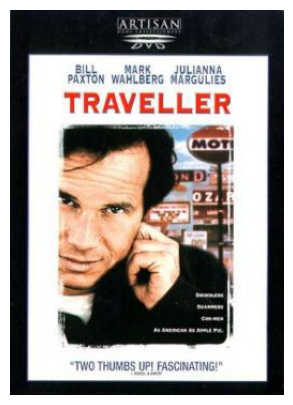

['A', 'Ġyoung', 'Ġman', ',', 'ĠPat', ',', 'Ġvisits', 'Ġthe', 'Ġclan', 'Ġof', 'Ġgy', 'psy', '-', 'like', 'Ġgr', 'if', 'ters', 'Ġ(', 'Irish', 'ĠTrave', 'llers', ')', 'Ġin', 'Ġrural', 'ĠNorth', 'ĠCarolina', 'Ġfrom', 'Ġwhom', 'Ġhe', 'Ġis', 'Ġdescended', '.', 'ĠHe', 'Ġis', 'Ġat', 'Ġfirst', 'Ġrejected', ',', 'Ġbut', 'Ġcousin', 'ĠBok', 'ky', 'Ġtakes', 'Ġhim', 'Ġon', 'Ġas', 'Ġan', 'Ġapprentice', '.', 'ĠPat', 'Ġlearns', 'Ġthe', 'Ġgame', 'Ġwhile', 'ĠBok', 'ky', 'Ġfalls', 'Ġin', 'Ġlove', 'Ġand', 'Ġdesires', 'Ġa', 'Ġdifferent', 'Ġlife', '.']
A young man, Pat, visits the clan of gypsy-like grifters (Irish Travellers) in rural North Carolina from whom he is descended. He is at first rejected, but cousin Bokky takes him on as an apprentice. Pat learns the game while Bokky falls in love and desires a different life.
['Crime', 'Drama', 'Romance']
Title:  Traveller
Kind:  movie
Year:  1997
Rating:  6.2


In [ ]:
import numpy as np

sample_movieID = 1247
# What is text_mask?
img, text, text_mask, labels = val_data[sample_movieID]

# Show input image.
plt.figure(figsize=(4,5));plt.imshow(img); plt.axis(False);plt.show()

# Show input plot (untokenized).
tokens = val_data.tokenizer.convert_ids_to_tokens(text, skip_special_tokens = True)
print(tokens)
print(val_data.tokenizer.convert_tokens_to_string(tokens))

# Show target labels (converted back to strings from binary vector).
labels = labels.numpy()
# Is there a better way to do this?
print([val_data.categories[ind] for ind, val in enumerate(labels == 1) if val == 1])

# You can look at other attributes for the movies on this dataset.
movie_metadata = val_data.get_metadata(sample_movieID)
print('Title: ', movie_metadata['smart canonical title'])
print('Kind: ', movie_metadata['kind'])
print('Year: ', movie_metadata['year'])
print('Rating: ', movie_metadata['rating'])

We explore below some of the images in the dataset that belong to the category `Drama`.

There are 382 movies of type Crime among 2608


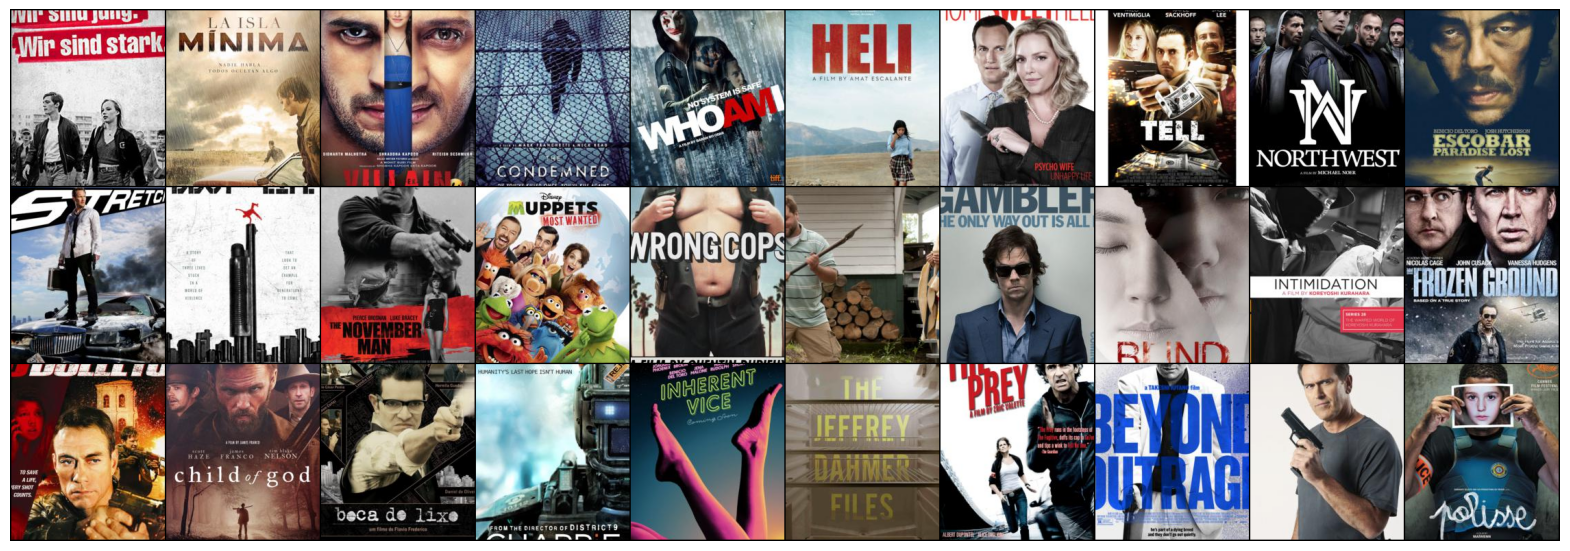

In [ ]:
import torchvision
import torchvision.transforms.functional as F
import torchvision.transforms as transforms

# Now let's display a bunch of posters for Crime movies.
movieType = 'Crime'
crime_ids = [id for id in range(0, len(val_data)) \
             if movieType in set(val_data.get_metadata(id)['genres'])]

print('There are %d movies of type %s among %d' %
      (len(crime_ids), movieType, len(val_data)))

def show_image_group(dataset, image_ids, n_images):
    image_ids = image_ids[:n_images]
    Transf = transforms.Compose([transforms.CenterCrop((256, 224)), transforms.ToTensor()])
    imgs = [Transf(dataset.load_image_only(id)) for id in image_ids]
    grid = torchvision.utils.make_grid(imgs, nrow = 10)
    plt.figure(figsize=(20,10)); plt.axis(False)
    plt.imshow(F.to_pil_image(grid));

# I'm passing the ids in reverse order, because it seems the movies are
# ordered from old to new in the dataset. Try the other way.
show_image_group(val_data, crime_ids[::-1], 30)

#### **2. Classify the Movies into Genres (based on their Plots -- Text Classification) [3pts]**

For this assignment we will not just use RoBERTa encodings but we will use a pretrained RoBERTa model and "fine-tune" its parameters so they adapt to the text in this dataset and learn to give a score for each movie genre to each movie. This is commonly referred as transfer learning just as in the previous assignment but here our data is text. We will ignore the images in the dataset for this section.

##### **2.1. Setting up Data Loaders**

In the code below, we are loading the training, and validation splits and then testing the batch loaders.

In [ ]:
# Let's setup the data loaders and preprocessing.
import torchvision.transforms as transforms

# Batch size is a liming factor on constrained resources.
# only GPUs with a large memory can hold large batches.
batch_size = 10

image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

trainset = MovieDataset(split = 'train', image_transform = image_transform)
valset = MovieDataset(split = 'dev', image_transform = image_transform)

train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size = batch_size,
                                           shuffle = True,
                                           pin_memory = True,
                                           num_workers = 2)
val_loader = torch.utils.data.DataLoader(valset,
                                         batch_size = batch_size,
                                         shuffle = False)

Loading dataset-resized-256max/train/metadata ... finished
Tokenizing... finished
Loading dataset-resized-256max/dev/metadata ... finished
Tokenizing... finished


Testing what a sample batch looks like.

In [ ]:
(imgs, texts, text_masks, labels) = next(iter(val_loader))
print(imgs.shape, texts.shape, text_masks.shape, labels.shape)

torch.Size([10, 3, 224, 224]) torch.Size([10, 256]) torch.Size([10, 256]) torch.Size([10, 27])


##### **2.2. Loading the predefined RoBERTa Transformer Model**

Here we initialize the pretrained RoBERTa model from the huggingface transformers library. They have several slightly different versions of it that are slightly modified for different tasks so you don't need to manually modify it (e.g. replacing last layer with something else) for your particular task. Do not be surprised if Google Colab keeps crashing. This is a very heavy model so I would recommend only running this cell once. Or if you have to run it twice, you might have to restart the runtime.

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaConfig

# Defining as global the device to use (by default CPU).
device = torch.device("cuda")

# Loading RoBERTa...
num_categories = len(trainset.categories)
model = RobertaForSequenceClassification.from_pretrained('roberta-base',
    num_labels = num_categories,  output_attentions = False,
    output_hidden_states = False)

# Tell pytorch to run this model on the GPU.
model.to(device);

# Let's run a quick test on this model.
output = model(texts.to(device), text_masks.to(device))
print(output.logits.shape)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should pr

torch.Size([10, 27])


##### **2.3. Training Loop for finetuning this RoBERTa Model**
Not very different than a training loop for training a model based on convolutional neural networks. However, please pay close attention to the differences and ask questions in Piazza. Moreover, this code is a bit imperfect as measuring top5_accuracy as performed here is not ideal and printing every 100 batches instead of at the end of every epoch also leads to some subpar visualization of progress. Nevertheless when I wrote this code the model seemed to be training well as evidenced by running some validation examples and computing overall accuracies later. If you re-run this cell it will take about 30 minutes to run depending on the GPU configuration used. For me it took about 20 minutes on the basic free tier T4 GPU from Google Colab.

In [ ]:
from transformers import get_linear_schedule_with_warmup
from livelossplot import PlotLosses
import torch.nn as nn

In [ ]:
num_epochs = 4

# Defining as global the device to use (by default CPU).
device = torch.device("cuda")

# Following recommendations from the BERT paper and also this
# blog post https://mccormickml.com/2019/07/22/BERT-fine-tuning/
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Binary Cross-Entroy Loss (BCE Loss).
# Please see documentation here:
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
cost_function = nn.BCEWithLogitsLoss(reduction = 'none')

# Are the top five scored labels accurate?
def top5_accuracy(predicted, labels):
    sorted_vals, sorted_ids = \
        predicted.data.sigmoid().sort(dim = 1, descending = True)
    pred_vals = sorted_vals[:, :5] > 0.5 # Anything with sigmoid > 0.5 is 1.
    true_vals = labels.data.gather(1, sorted_ids[:, :5]) # Find true values.
    return (pred_vals == true_vals).sum(dim = 1) / 5.0

# DON'T RUN THE BELOW CELL AGAIN, LOAD THE MODEL FROM THE NEXT CELL

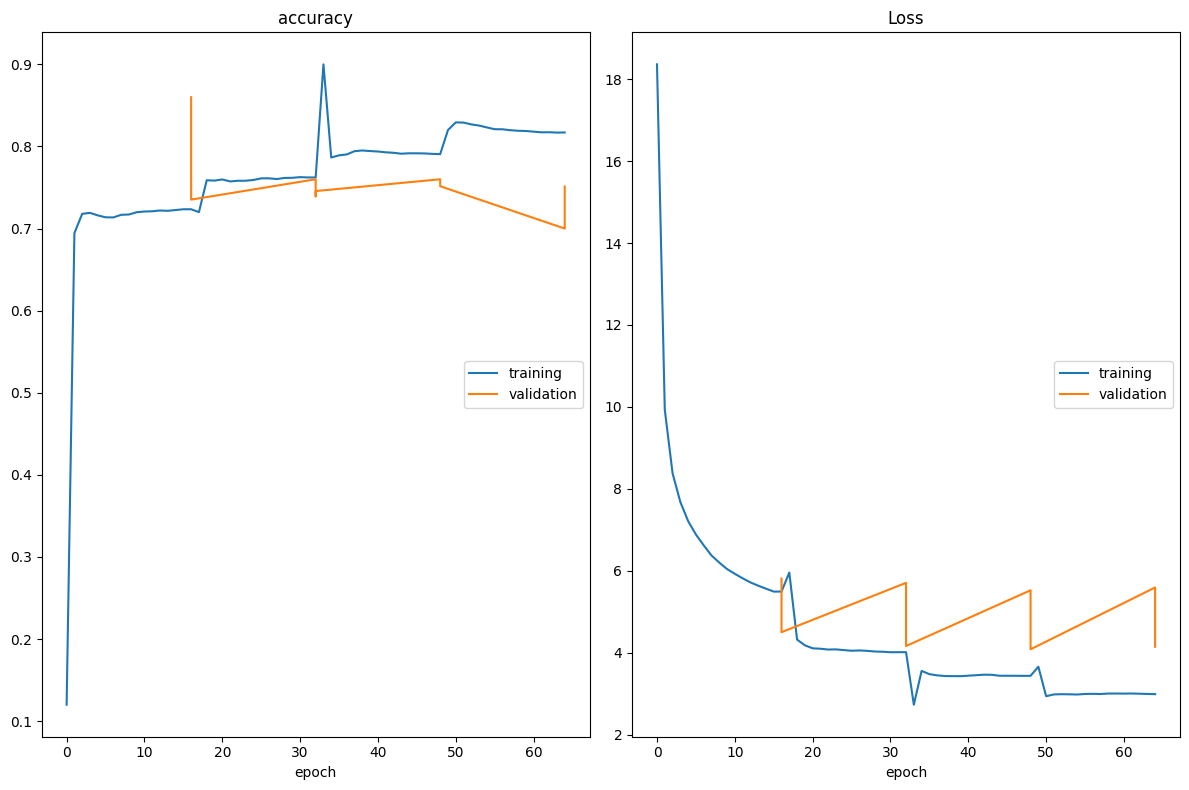

accuracy
	training         	 (min:    0.120, max:    0.900, cur:    0.817)
	validation       	 (min:    0.700, max:    0.860, cur:    0.751)
Loss
	training         	 (min:    2.733, max:   18.361, cur:    2.990)
	validation       	 (min:    4.085, max:    5.810, cur:    4.147)


In [ ]:
# Training Loop.
best_accuracy = 0
liveloss = PlotLosses(); current_step = 0
for epoch in range(0, num_epochs):
    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    logs = {}
    model.train()
    for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(train_loader):
        # Move to GPU.
        texts = texts.to(device)
        text_masks = text_masks.to(device)
        labels = labels.to(device)

        # Compute predictions.
        predicted = model(texts, text_masks)

        # Compute loss.
        loss = cost_function(predicted.logits, labels)

        # Compute cumulative loss and top-5 accuracy.
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top5_accuracy(predicted.logits, labels).sum().item()
        num_samples += texts.size(0)

        # Backpropagation and SGD update step.
        model.zero_grad()
        loss.mean().backward()
        optimizer.step()

        if batch_id % 100 == 0:
            print(epoch, batch_id, cumulative_accuracy / num_samples)
            logs['loss'] = cumulative_loss / num_samples
            logs['accuracy'] = cumulative_accuracy / num_samples
            liveloss.update(logs)
            liveloss.send()
            current_step += 1

    cumulative_accuracy = 0
    cumulative_loss = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
      for (batch_id, (imgs, texts, text_masks, labels)) in enumerate(val_loader):
          # Move to GPU.
          texts = texts.to(device)
          text_masks = text_masks.to(device)
          labels = labels.to(device)

          # Compute predictions.
          predicted = model(texts, text_masks)

          # Compute loss.
          loss = cost_function(predicted.logits, labels)

          # Compute cumulative loss and top-5 accuracy.
          cumulative_loss += loss.data.sum().item()
          cumulative_accuracy += top5_accuracy(predicted.logits, labels).sum().item()
          num_samples += texts.size(0)

          if batch_id % 100 == 0:
              logs['val_loss'] = cumulative_loss / num_samples
              logs['val_accuracy'] = cumulative_accuracy / num_samples
              liveloss.update(logs, current_step)
              liveloss.send()

    # Advance scheduler.
    if scheduler != -1:
        scheduler.step()

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far.pth')

In [ ]:
#torch.save(model, '/content/drive/MyDrive/COMP646/Asst2/best_model_so_far.pth')

# LOAD MODEL -->

In [84]:
model = torch.load('/content/drive/MyDrive/COMP646/Asst2/best_model_so_far.pth')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/COMP646/Asst2/best_model_so_far.pth'

##### **2.4. Loading model weights from a file**
Training the model in the previous section might take about an hour -- instead we can load a model that has been pretrained already. Feel free to retrain but here I provide a model I trained myself by running the code in the preceding section.

In [ ]:
# I uploaded a "checkpoint" of this model that I trained on Google Drive.
# Try saving and uploading your model to Google Drive as well.
#!gdown 1kn4lza3l17AVlUFkpFah0MOvBTHsvWk1 # This won't work sometimes.
# The link below will always work but will be slower.
!wget -nc https://www.cs.rice.edu/~vo9/deep-vislang/best_roberta_model_so_far-comp646-spring2024.pth
model.load_state_dict(torch.load('best_roberta_model_so_far-comp646-spring2024.pth'))
model.eval();

--2024-02-11 22:16:06--  https://www.cs.rice.edu/~vo9/deep-vislang/best_roberta_model_so_far-comp646-spring2024.pth
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 498754922 (476M)
Saving to: ‘best_roberta_model_so_far-comp646-spring2024.pth’

best_roberta_model_ 100%[===================>] 475.65M  5.51MB/s    in 86s     

2024-02-11 22:17:33 (5.50 MB/s) - ‘best_roberta_model_so_far-comp646-spring2024.pth’ saved [498754922/498754922]



In [ ]:
model.to(device);

##### **2.5 Show the predictions for a few input texts [0.5pts]**
Show the top five classification predictions of the BERT model for a few input plots, as shown below. In order to obtain probability scores you need to understand what the **`nn.BCEWithLogitsLoss`** is doing when training the prediction scores. Take into account that since we are dealing with multi-class classification, this is not a softmax classifier trained with a cross entropy loss (nn.CrossEntropyLoss), ie. prediction scores don't add up to 1. You also need to know what functions to call to convert the tokenized text back into a regular text.

In [ ]:
input = "this biopic follows rommel ' s career after the afrika korps , including his work on the defenses of fortress europe as well as his part in the assassination attempt on hitler , and his subsequent suicide ."
tmp_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
encoded_text = tmp_tokenizer.encode_plus(
                  input, add_special_tokens = False, truncation = True,
                  max_length = 256, padding = 'max_length',
                  return_attention_mask = True,
                  return_tensors = 'pt')
text = encoded_text['input_ids']
text_mask = encoded_text['attention_mask']

In [ ]:
text.shape, text_mask.shape

(torch.Size([1, 256]), torch.Size([1, 256]))

In [ ]:
text = text.to(device)
text_mask = text_mask.to(device)

In [ ]:
prediction = model(text, text_mask).logits
# probs=torch.sigmoid(prediction)
# print('cat',probs)
# print('dog',unsorted_ids)
sorted_vals, sorted_ids = prediction.data.sigmoid().sort(dim = 1, descending = True)
# print('anu',sorted_vals)
# print('manu',sorted_ids)

print("##################                        INPUT                        ################## \n ######################################################################################### \n \"this biopic follows rommel ' s career after the afrika korps , including his work on the defenses of fortress europe as well as his part in the assassination attempt on hitler , and his subsequent suicide .\" \n #########################################################################################")

for idx in range(5):
  print("P[{}] = {:.2f}".format(valset.categories[sorted_ids[0][idx].item()], sorted_vals[0][idx].item()))
print("Ground Truth Labels: ['Biography', 'Drama', 'War']")

##################                        INPUT                        ################## 
 ######################################################################################### 
 "this biopic follows rommel ' s career after the afrika korps , including his work on the defenses of fortress europe as well as his part in the assassination attempt on hitler , and his subsequent suicide ." 
 #########################################################################################
P[Drama] = 0.93
P[History] = 0.84
P[Biography] = 0.60
P[War] = 0.48
P[Action] = 0.39
Ground Truth Labels: ['Biography', 'Drama', 'War']


##### **2.6 Compute the mean average precision (meanAP) of this model [1pt]**
During training we computed a very crude metric of accuracy we called top5_accuracy which has several failings (a) It only measures the quality of the top 5 predictions, and (b) Most movies only have one or two labels associated with them, meaning most of the top5 predictions should be zero, hence the accuracy rewards models that predict everything as zero as very accurate even if they never predict the correct labels as correct. For these reasons this metric can be "gamed". A more appropriate metric for multi-label classication is the mean average precision. Use sklearn's metrics.average_precision_score to compute the meanAP for the model trained by the instructor.

In [ ]:
from sklearn.metrics import average_precision_score
import numpy as np
all_labels = []
all_predictions=[]
with torch.no_grad():
    for (idx ,(imgs, texts, text_masks, labels)) in enumerate(val_loader):
        # if idx >= 2:
        #   break
        texts = texts.to(device)
        text_masks = text_masks.to(device)
        prediction = torch.sigmoid(model(texts, text_masks).logits)
        all_labels.append( labels.cpu().numpy())
        all_predictions.append(prediction.cpu().numpy())

all_labels = np.vstack(all_labels)
all_predictions=np.vstack(all_predictions)
ap_score = average_precision_score(all_labels,all_predictions, average='macro')
print("Mean Average Precision:",ap_score)

Mean Average Precision: 0.535232623197458


##### **2.6. Show the posters for movies rated as Adventure with the highest score by the RoBERTa model. [0.5pts]**

Use the show_image_group function provided earlier to show the top 30 images scored with the highest scores by the RoBERTa model as ```Adventure```. Make sure you use the provided model checkpoint. Everyone should get the same set of images on this section. **Note:** I know the model is not scoring the movies based on the movie poster at all but it seems easier to judge by movie poster for a quick visual inspection as it doesn't require reading text.

In [ ]:
adv_ids=[]
with torch.no_grad():
    for (idx ,(imgs, texts, text_masks, labels)) in enumerate(val_loader):
        texts = texts.to(device)
        text_masks = text_masks.to(device)
        prediction = model(texts, text_masks).logits
        for i in range(prediction.shape[0]):
          anu=prediction[i][valset.categories2ids['Adventure']]
          adv_ids.append([anu,idx*10+i])
    # print(adv_ids)


In [ ]:
sorted_adv_ids = sorted(adv_ids, key=lambda x: x[0], reverse=True)
just_ids = [just_id[1] for just_id in sorted_adv_ids]
# print(just_ids[:30])

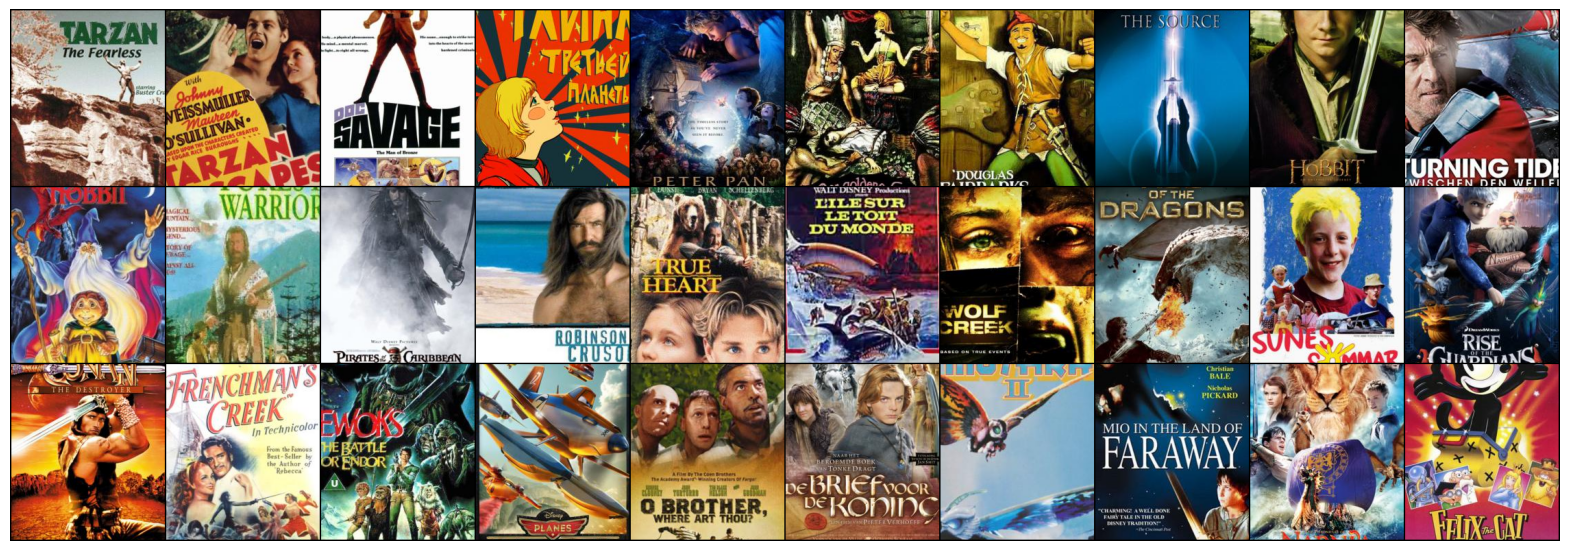

In [ ]:
show_image_group(val_data,just_ids[:30],30)

#### **3. Classify the Movies into Genres (based on their Posters -- Images) [2pts]**




In this section we only need to apply what was learned from the previous assignment. The task is to finetune a model to predict these 27 movie genres from the movie poster images. Re-use code from the previous sections, the previous assignment, and the previous assignment solutions, as appropriate. You have to at least show your training/validation accuracy and loss plots showing the model is learning and has converged. Report details of your solution in the [leaderboard](https://docs.google.com/spreadsheets/d/1nwtXxg6tcOHf5_IeOLs1gbseX1vvJMDYSpbhNaAore8/edit?usp=sharing) along with your meanAP score. A minimum meanAP required to obtain full points will be announced later.

In [ ]:
from torchvision import models
import torch.nn as nn


model = models.resnet101(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 27)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 63.5MB/s]


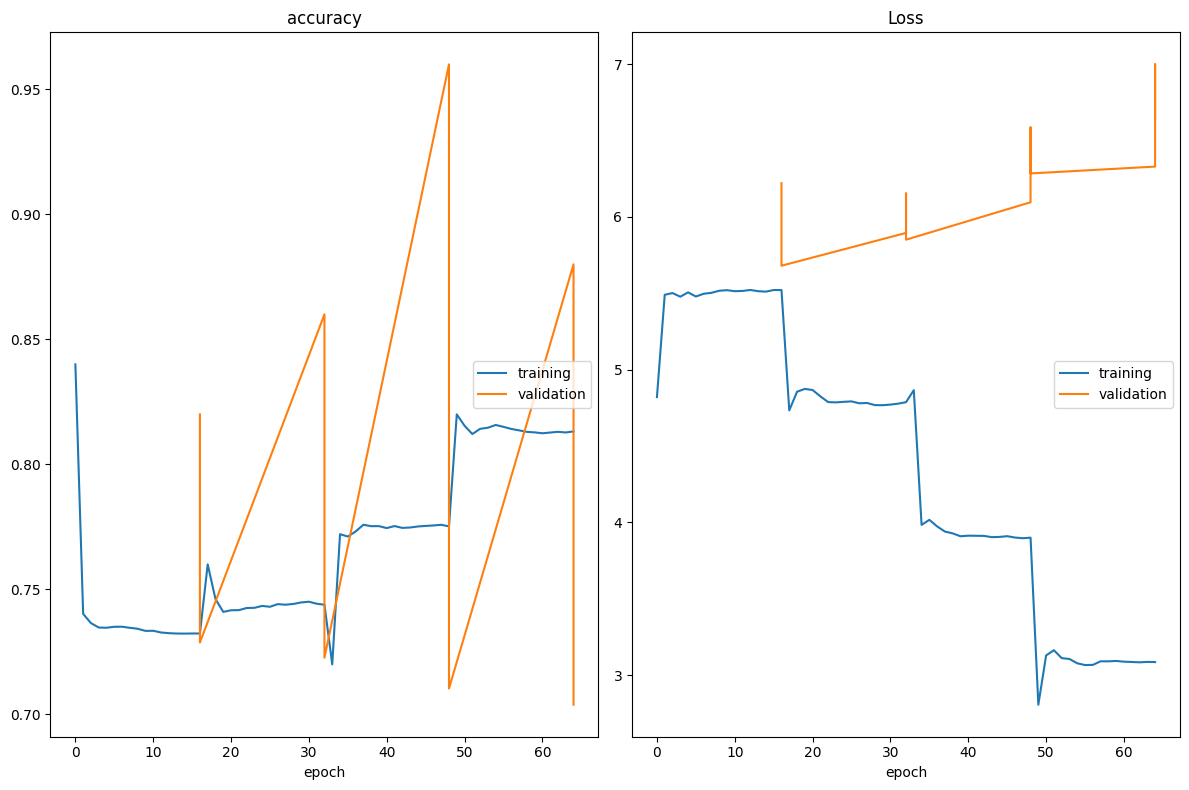

accuracy
	training         	 (min:    0.720, max:    0.840, cur:    0.813)
	validation       	 (min:    0.704, max:    0.960, cur:    0.704)
Loss
	training         	 (min:    2.807, max:    5.522, cur:    3.086)
	validation       	 (min:    5.681, max:    6.999, cur:    6.645)
Time taken in secs:  1267.9252326488495


In [ ]:
import torch
from sklearn.metrics import accuracy_score
import time as time
start_time=time.time()

model.to(device)

# Setup optimizer, scheduler, and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
cost_function = nn.BCEWithLogitsLoss(reduction= 'none')
current_step = 0

# Training and validation loop

def top5_accuracy(predicted, labels):
    sorted_vals, sorted_ids = \
        predicted.data.sigmoid().sort(dim = 1, descending = True)
    pred_vals = sorted_vals[:, :5] > 0.5 # Anything with sigmoid > 0.5 is 1.
    true_vals = labels.data.gather(1, sorted_ids[:, :5]) # Find true values.
    return (pred_vals == true_vals).sum(dim = 1) / 5.0

liveloss = PlotLosses()
for epoch in range(num_epochs):
    cumulative_loss = 0.0
    val_loss = 0.0
    cumulative_accuracy = 0
    num_samples = 0
    num_label_predictions = 0
    logs = {}

    model.train()
    for batch_id, (imgs, _, _, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        predicted = model(imgs)
        loss = cost_function(predicted, labels)
        cumulative_loss += loss.data.sum().item()
        cumulative_accuracy += top5_accuracy(predicted, labels).sum().item()
        num_samples += imgs.size(0)

        model.zero_grad()
        loss.mean().backward()
        optimizer.step()

        if batch_id % 100 == 0:
          logs['loss'] = cumulative_loss / num_samples
          logs['accuracy'] = cumulative_accuracy / num_samples
          liveloss.update(logs)
          liveloss.send()
          current_step += 1



    # Reset for validation
    cumulative_accuracy = 0
    num_samples = 0
    num_label_predictions = 0
    model.eval()
    with torch.no_grad():
        for batch_id, (imgs, _, _, labels) in enumerate(val_loader):
            imgs= imgs.to(device)
            labels =  labels.to(device)
            predicted = model(imgs)
            loss = cost_function(predicted, labels)

            val_loss += loss.data.sum().item()
            cumulative_accuracy += top5_accuracy(predicted, labels).sum().item()
            num_samples += imgs.size(0)




            if batch_id % 100 == 0:
              logs['val_loss'] = val_loss / num_samples
              logs['val_accuracy'] = cumulative_accuracy / num_samples
              liveloss.update(logs, current_step)
              liveloss.send()

    if scheduler != -1:
      scheduler.step()

end_time=time.time()
print("Time taken in secs: ", end_time-start_time)

In [ ]:
from sklearn.metrics import average_precision_score
import numpy as np
all_labels = []
all_predictions=[]
with torch.no_grad():
    for (idx ,(imgs, _, _, labels)) in enumerate(val_loader):
        # if idx >= 2:
        #   break
        imgs = imgs.to(device)
        prediction = model(imgs)
        all_labels.append( labels.cpu().numpy())
        all_predictions.append(prediction.cpu().numpy())

all_labels = np.vstack(all_labels)
all_predictions=np.vstack(all_predictions)
ap_score = average_precision_score(all_labels,all_predictions, average='macro')
print("Mean Average Precision:",ap_score)

Mean Average Precision: 0.2766402906007282


**Required answer:** Is this model better than the text classifier in terms of top-5 accuracy as computed earlier? Which one is better?

#### **4. Zero-shot Text Classification with FLAN-T5 [3pts]**

Some really impressive tools have been developed in the past few years with transformer neural networks. Auto-regressive neural networks allow one to predict the next element in a sequence given the previous elements. We can cast almost any problem involving text in this way incluing text classification. In December 2022 Google released [FLAN-T5](https://arxiv.org/pdf/2210.11416.pdf), a powerful language model that on top of being pre-trained to predict the next word in a sequence, it was finetuned to follow instructions for a variety of tasks. The following figure shows some examples:
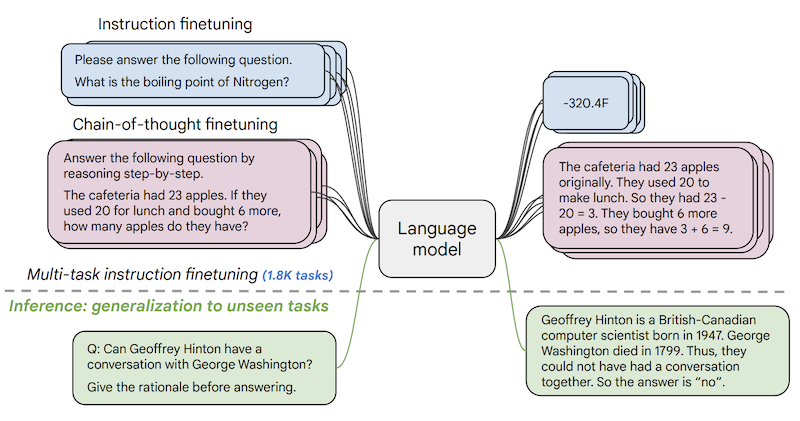


This network is included in the Hugginface transformers 🤗 library and you can try it interactively here: https://huggingface.co/google/flan-t5-xl

Use this network to predict the genre of the movies from the MMIMDB dataset. **Note:** You are not allowed to train this network, you should use the network as-is. You need to design a classifier that can tell you the genre of the movie given a movie plot purely using this language model to give you the answers and some scores. Please use the link above to try different ideas. Report your meanAP as computed earlier in the assignment for the Movie Plot classification task here in this [leaderboard](https://docs.google.com/spreadsheets/d/1RXA4arGV-afICL5ZpHBrtvKOniX9g72KNTfm0wpl_fo/edit?usp=sharing). A minimum meanAP required to get full points will be announced later. Keep in mind that in order to compute meanAP you need for every move a prediction score for every possible label.

Replace the cell below with your solution, you need to report the meanAP for your solution.

In [63]:
!pip -q install transformers==4.26.0
!pip -q install sentencepiece
!pip -q install accelerate

In [64]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the language model and its tokenizer.
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large")
model = model.to('cuda')

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [65]:
input_text = '''In the following sentence who is "their" referring to?:
                Input: The janitor asks the receptionist where to go because this is their first day here..
                Answer:'''
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")
outputs = model.generate(input_ids, max_new_tokens = 20, output_scores = True, return_dict_in_generate = True)

# You can also obtain the output scores (probabilities) over the vocabulary
# by looking into outputs.scores
print('len(outputs.scores) = ', len(outputs.scores))
print('len(outputs.sequences[0]) = ', len(outputs.sequences[0]))
aslist = outputs.sequences[0].cpu().numpy().tolist()
print('outputs.sequences[0] = ', aslist)
print('untokenize(outputs.sequences[0]) = ', tokenizer.convert_ids_to_tokens(aslist, skip_special_tokens=True))
print(tokenizer.decode(outputs.sequences[0]))

len(outputs.scores) =  6
len(outputs.sequences[0]) =  7
outputs.sequences[0] =  [0, 37, 3, 7066, 155, 127, 1]
untokenize(outputs.sequences[0]) =  ['▁The', '▁', 'jan', 'it', 'or']
<pad> The janitor</s>


In [66]:
valset = MovieDataset(split = 'dev', tokenizer = None)

Loading dataset-resized-256max/dev/metadata ... finished
Tokenizing... finished


In [67]:
img, text, labels = valset[111]
print(text, "\n", labels)

Meeting a movie team on location near his house, a young man saw a lots of encouragment for his dreaming carreer as a movie star in what was only sarcasm from the members of the team. (This is the caracteristic of a schountz: someone who see himself as a born movie comedian and is blind on the critics to his dream) After he has signed a fake contract which he blindly take as genuine even if it is ridiculous, he starts to Paris without money to make his carreer. 
 tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [68]:
# Testing different prompts on dummy input
import random

input_prompt_templates = ['Which of the genres from the given genres list can this movie belong to? If there are multiple answers, use a comma separated list.']
genres_list = '''Genres: ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']'''
input_prompt = input_prompt_templates[random.randint(0, len(input_prompt_templates)-1)]
input_text = "Movie Plot: " + text + input_prompt + genres_list
print(input_prompt)
input_ids = tokenizer(input_text, add_special_tokens=True, truncation = True, max_length = 512, return_tensors="pt").input_ids.to("cuda")
outputs = model.generate(input_ids, min_new_tokens=1, max_new_tokens = 5, output_scores = True, return_dict_in_generate = True, use_cache=False)

# You can also obtain the output scores (probabilities) over the vocabulary
# by looking into outputs.scores
print('len(outputs.scores) = ', len(outputs.scores))
print('len(outputs.sequences[0]) = ', len(outputs.sequences[0]))
aslist = outputs.sequences[0].cpu().numpy().tolist()
print('outputs.sequences[0] = ', aslist)
print('untokenize(outputs.sequences[0]) = ', tokenizer.convert_ids_to_tokens(aslist, skip_special_tokens=True))
print(tokenizer.decode(outputs.sequences[0]))

Which of the genres from the given genres list can this movie belong to? If there are multiple answers, use a comma separated list.
len(outputs.scores) =  2
len(outputs.sequences[0]) =  3
outputs.sequences[0] =  [0, 26984, 1]
untokenize(outputs.sequences[0]) =  ['▁Comedy']
<pad> Comedy</s>


In [69]:
outputs.scores[0].shape, outputs.scores[1].shape

(torch.Size([1, 32128]), torch.Size([1, 32128]))

In [70]:
def get_flan_prediction(dataset, labels_aslist):
  prediction_cats = []
  hyphen_cats = {'SciFi': 'Sci-Fi', 'FilmNoir': 'Film-Noir', 'RealityTV': 'Reality-TV', 'TalkShow': 'Talk-Show'}
  for cat in labels_aslist:
    key = re.sub(r'[^\w\s]', '', cat)
    if key in dataset.categories:
      prediction_cats.append(dataset.categories2ids[key])
    elif key in hyphen_cats.keys():
      prediction_cats.append(dataset.categories2ids[hyphen_cats.get(key)])
    else:
      pass
  return list(set(prediction_cats))

In [71]:
from tqdm import tqdm
import re
from sklearn.preprocessing import label_binarize

predictions = []
n_prompts = len(input_prompt_templates)-1

with torch.no_grad():
  for (batch_id, (img, text, labels)) in tqdm(enumerate(valset)):
    prediction = [0] * 27
    input_prompt = input_prompt_templates[random.randint(0, n_prompts)]
    input_text = "Movie Plot: "+ text + input_prompt + genres_list
    input_id = tokenizer(input_text, add_special_tokens=True, truncation = True, max_length = 512, return_tensors="pt").input_ids.to("cuda")
    output = model.generate(input_id, min_new_tokens=3, max_new_tokens = 5, output_scores = True, use_cache=False, return_dict_in_generate = True)
    #aslist = output.sequences[0].cpu().numpy().tolist()
    labels_aslist = tokenizer.decode(output.sequences[0], skip_special_tokens=True).split(', ')
    pred_labels = get_flan_prediction(valset, labels_aslist)
    for pred_class in pred_labels:
      prediction[pred_class] = 1
    predictions.append(prediction)

2608it [12:34,  3.46it/s]


In [73]:
true_labels = [label.type(torch.int8).tolist() for (img, text, label) in valset]

In [74]:
from sklearn.metrics import average_precision_score
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
mean_ap = average_precision_score(true_labels, predictions)
print("Mean Average Precision: ", mean_ap*100, "%")

Mean Average Precision:  17.036065433874715 %


#### **5. Zero-shot Image Classification with CLIP [3pts]**



In January 2021, OpenAI published a research paper named CLIP ([Contrastive Language-Image Pretraining](https://arxiv.org/abs/2103.00020)) https://openai.com/blog/clip/. This model was trained to maximize the dot product between vector representations of text and images that have a direct correspondence and minimize their dot product when they do not correspond. One key property of this model is that it can be used to build zero-shot classifier. Since the model was trained on a large number of images and text from the web, this model knows about a lot of categories of things. Your goal in this section is to obtain the best results using the illustrated approach in this figure for the scene classification problem of Assignment 1 (SUN20). Please enter the best classification accuracy in the [leaderboard](https://docs.google.com/spreadsheets/d/1nxMrLCZat2dL2fodsFkxwoMGZgHvJ49hoiC2InINIsc/edit?usp=sharing) here using CLIP. [To get full points obtain more than 92% accuracy]

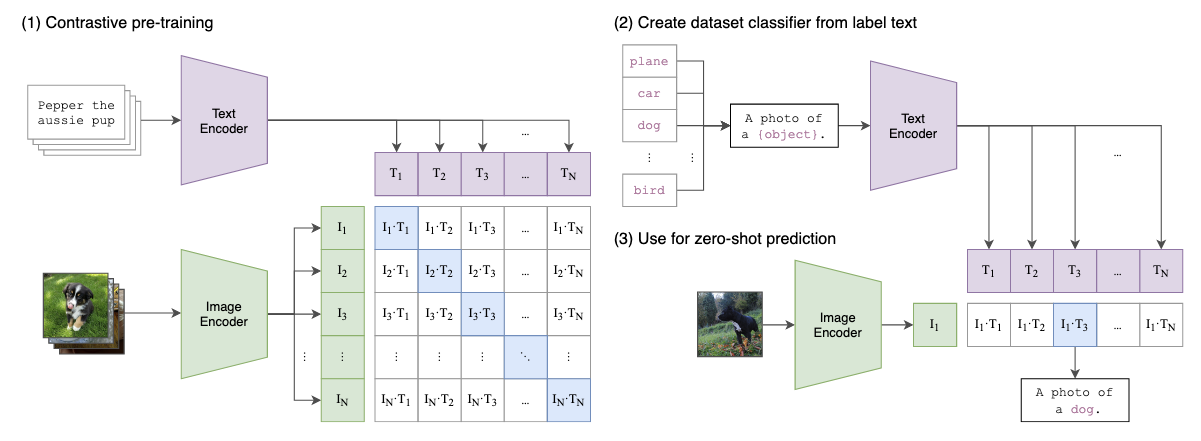

In [75]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-rmycyhle
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-rmycyhle
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=71c6ac937ccc1dc1c54e0a7fb8891d148f99f34dcdb133ace118b8c2298da63e
  Stored in directory: /tmp/pip-ephem-wheel-cache-2e1lv10r/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [76]:
import os
import clip
import torch
import numpy as np
from tqdm import tqdm

In [77]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 133MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [78]:
# Download the dataset
!wget -nc http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz
!wget -nc http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-val.tar.gz
!tar xf SUN20-train-sm.tar.gz
!tar xf SUN20-val.tar.gz

--2024-02-12 00:48:14--  http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:80... connected.
HTTP request sent, awaiting response... 302 Found : Moved Temporarily
Location: https://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz [following]
--2024-02-12 00:48:15--  https://www.cs.rice.edu/~vo9/deep-vislang/SUN20-train-sm.tar.gz
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39744791 (38M) [application/x-gzip]
Saving to: ‘SUN20-train-sm.tar.gz’

SUN20-train-sm.tar. 100%[===================>]  37.90M  5.32MB/s    in 7.2s    

2024-02-12 00:48:22 (5.27 MB/s) - ‘SUN20-train-sm.tar.gz’ saved [39744791/39744791]

--2024-02-12 00:48:22--  http://www.cs.rice.edu/~vo9/deep-vislang/SUN20-val.tar.gz
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connecti

In [79]:
import os, json, pickle, random
import torch.utils.data
from PIL import Image

# Simple implementation of a custom data loading class for our SUN20 dataset.
class SUN20(torch.utils.data.Dataset):

  # Initialize the class e.g. load files, preprocess, etc.
  def __init__(self, split = 'train', transform = None):

    # These are the 20 categories selected.
    self.categories = open('SUN20/' + split + '/ClassName.txt').read().split('\n')[:-1]
    self.categories = sorted(self.categories)
    self.category2index = {category: idx for (idx, category) in enumerate(self.categories)}
    self.transform = transform

    # Compile a list of images and corresponding labels.
    self.imagepaths = []
    self.labels = []
    for category in self.categories:
      category_directory = 'SUN20/' + split + category
      category_imagenames = os.listdir(category_directory)
      self.imagepaths += [os.path.join(category_directory, imagename)
                          for imagename in category_imagenames]
      self.labels += [self.category2index[category]] * len(category_imagenames)

    # Sort imagepaths alphabetically and labels accordingly.
    sorted_pairs = sorted(zip(self.imagepaths, self.labels), key = lambda x: x[0])
    self.imagepaths, self.labels = zip(*sorted_pairs)


  # Return a sample (x, y) as a tuple e.g. (image, label)
  def __getitem__(self, index):
    image = Image.open(self.imagepaths[index]).convert('RGB')
    if self.transform:
      image = self.transform(image)
    return image, self.labels[index]

  # Return the total number of samples.
  def __len__(self):
    return len(self.imagepaths)


In [80]:
trainset = SUN20(split = 'train')
valset = SUN20(split = 'val')

In [81]:
# Prepare the inputs
image, class_id = valset[0]
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c[3:]}") for c in valset.categories]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{valset.categories[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

         /a/arch: 97.22%
       /s/shower: 1.55%
        /t/tower: 0.81%
   /h/hot_spring: 0.18%
     /b/bathroom: 0.07%


In [82]:
yhat = []

for (idx, (img, label)) in tqdm(enumerate(valset)):
  image_input = preprocess(img).unsqueeze(0).to(device)
  text_inputs = torch.cat([clip.tokenize(f"a photo of a {c[3:]}") for c in valset.categories]).to(device)

  # Calculate features
  with torch.no_grad():
      image_features = model.encode_image(image_input)
      text_features = model.encode_text(text_inputs)

  # Pick the top 5 most similar labels for the image
  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
  values, indices = similarity[0].topk(5)
  yhat.append(indices[0].item())

1000it [00:33, 29.90it/s]


In [83]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(valset.labels, yhat)
print(f'Accuracy of model: {accuracy * 100 :.2f} %')

Accuracy of model: 91.30 %
